# Chapter 04. CNN architectures(2)

경희대학교 Hyper동아리에서 사용하는 자료입니다<br>
제작 : 소프트웨어융합학과 문희준<br>
무단으로 자료의 배포 및 유출을 금합니다<br>

# 4. GoogLeNet (Inception module)

GoogLeNet은 2014년 ILSVRC에서 1위를 하였던 모델입니다<br>
GoogLeNet은 Google과 LeNet에서 따온 이름으로, **Inception block**을 담고 있다는 점에서 매우 중요합니다.
특히 **Inception block을 통해 위의 VGG에서 발생한 vanishing graident를 해결하였습니다**<br><br>

이제 GoogLeNet의 아키텍쳐를 자세하게 살펴보겠습니다.<br>
GoogLeNet은 AlexNet이나 VGG보다 **훨씬 적은 매개변수를 가지고 있습니다.**<br>
훨씬 가벼운 모델이며, 성능역시 우수하여 인기가 시들지 않고 있습니다<br><br>

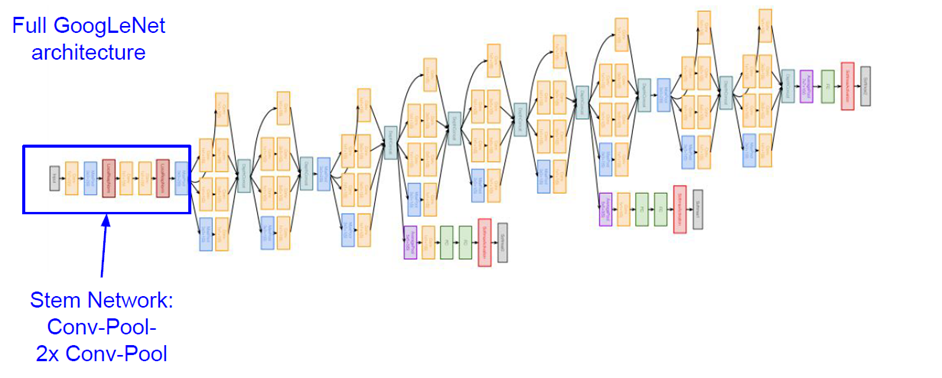

- **Inception module**<br>
아래 그림과 같이 네트워크 중간중간 인셉션 모듈을 둡니다.(아래 그림서는 9개의 인셉션 모듈이 존재합니다)<br>
각 인셉션 모듈은 다음과 같이 병렬구조로 여거개의 계층 블록으로 되어있습니다.<br>
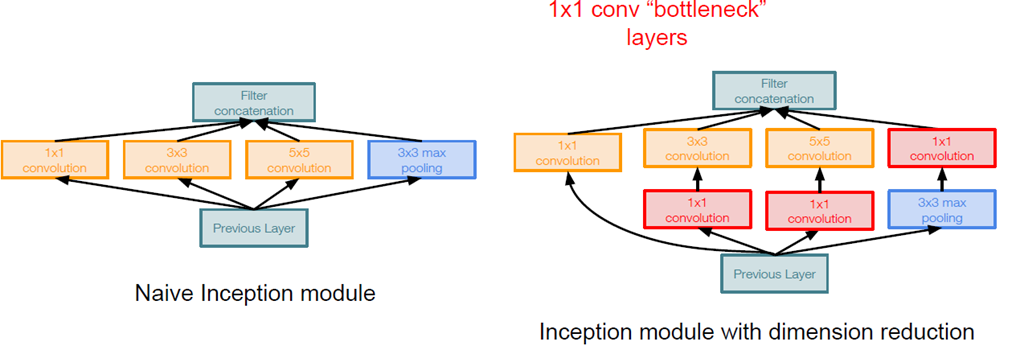

- **No FC-layers**<br>
GoogLeNet은 마지막에 FC layer가 없는 대신에, average pooling layer를 사용합니다<br><br>

**이제 GoogLeNet의 중요한 특징들에 관하여 상세히 설명드리겠습니다**
## 1. 인셉션 모듈로 세부 특징 잡아내기
기본 인셉션 모듈은 3개의 합성곱 계층과 1개의 maxPooling으로 구성됩니다.<br>
각 계층의 결과를 하나로 연결해 최종 결과를 만드는 이 병렬 처리의 이점은 여러가지가 있습니다<br>
**먼저 다양한 데이터의 처리를 가능하게 해줍니다**<br>
각 인셉션 모듈의 결과는 다양한 척도의 특징을 결합하여 광범위한 정보를 잡아냅니다<br>
이 경우 **최선의 커널 크기를 정해주지 않아도 된다는 장점이 있습니다**<br>
**즉, 네트워크가 각 모듈에 대해 어느 합성곱 계층에 의존하였는지를 학습합니다**<br>

## 2. 병목 계층으로 1x1 합성곱 계층을 사용
**1x1 합성곱 계층은 모델의 구조에 영향을 주지 않고 깊이를 변경하기 위해 사용됩니다**<br>
예를 들어 N개의 1x1필터를 갖는 계층은 입력이 HxWxD인 경우 HxWxN을 결과로 반환합니다<br>
이 속성을 잘 사용하면은, N<D인 경우 **특징 깊이를 줄임으로써 매개변수의 갯수를 줄일 수 있습니다.**<br>

## 3. 완전 연결 계층 대신 풀링 계층의 사용
앞서 위에서 설명드렸다 싶이, **완전 연결 계층(FC layer)대신 average Pooling을 이용하여 매개변수의 수를 줄였습니다**<br>
물론 pooling을 이용하면 네트워크가 표현력을 약간 잃게 되지만, 줄어드는 계산량의 이익이 더 큽니다<br>

## 4. 중간 손실로 경사 소실 문제 해결하기
**GoogLeNet은 auxiliary classifier를 중간에 두어서 Vanishing gradient의 문제를 해결합니다**<br>
각각의 auxiliary classifier에서 분류한 결과를 이용하여 gradient값을 이용하여 각각 update를 해줍니다<br>
**즉,깊은 구조를 여러개의 auxiliary classifier의 도입을 통해 divide & conquer 한다고 생각하면 될 것 같습니다<br>**
auxialry 사진<br>

아래에서는 처음 논문에 제시된 GoogLeNet을 직접 구현해보겠습니다

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [2]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1000, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

Keras에서는 VGG와 마찬가지로 모듈로 개선된 GoogLeNet을 제공하고 있습니다.<br>

In [3]:
import tensorflow as tf

model = tf.keras.applications.InceptionV3()
print(model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

다음은 tensorflow dataset에 있는 flower data를 이용하여 모델을 학습시켜보겠습니다.

## Load data

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

(training, validation), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]','train[70%:]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
)

# print dataset Info
dataset_info


Dataset tf_flowers downloaded and prepared to /Users/hayoon/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/Users/hayoon/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [5]:
# Print number of classes, Training images, Validation Images
num_classes = dataset_info.features['label'].num_classes
print('classes:',num_classes)

num_train = 0
num_val = 0

for elem in training:
    num_train += 1
for elem in validation:
    num_val += 1

print('Training:',num_train)
print('Validation:',num_val)

classes: 5
Training: 2569
Validation: 1101


## Resizing image

In [6]:
import numpy as np

IMAGE_RES = 299
Batch_size = 32

def format_image(image, label):
    image = tf.image.resize(image,(IMAGE_RES, IMAGE_RES))/255.0 # normalize
    return image, label

train = training.shuffle(num_train//4).map(format_image).batch(Batch_size).prefetch(1) # mapping을 이용하여 shuffle 해준다
validation = validation.map(format_image).batch(Batch_size).prefetch(1)

print(train)
print(validation)

<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>


## Compile, train model
이제 GoogLeNet을 이용하여 모델을 직접 빌드하고 훈련시켜 보겠습니다!

In [7]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Train
model.fit(train, batch_size=Batch_size, epochs=20, validation_data=validation)

Epoch 1/20
81/81 [==============================] - 1066s 13s/step - loss: 0.8589 - accuracy: 0.7629 - val_loss: 2.7210 - val_accuracy: 0.4323
Epoch 2/20
81/81 [==============================] - 1053s 13s/step - loss: 0.4272 - accuracy: 0.8513 - val_loss: 1.0549 - val_accuracy: 0.7293
Epoch 3/20
81/81 [==============================] - 1056s 13s/step - loss: 0.3480 - accuracy: 0.8750 - val_loss: 1.5137 - val_accuracy: 0.6058
Epoch 4/20
81/81 [==============================] - 1062s 13s/step - loss: 0.2925 - accuracy: 0.9046 - val_loss: 0.5930 - val_accuracy: 0.8129
Epoch 5/20
81/81 [==============================] - 1329s 16s/step - loss: 0.2215 - accuracy: 0.9253 - val_loss: 0.6022 - val_accuracy: 0.8193
Epoch 6/20
81/81 [==============================] - 1317s 16s/step - loss: 0.1961 - accuracy: 0.9385 - val_loss: 0.8913 - val_accuracy: 0.7775
Epoch 7/20
81/81 [==============================] - 1063s 13s/step - loss: 0.2551 - accuracy: 0.9136 - val_loss: 1.6696 - val_accuracy: 0.6939

## Visualize model predictions
정답인 경우에는 파란색, 오답인 경우는 빨간색으로 표시하였습니다

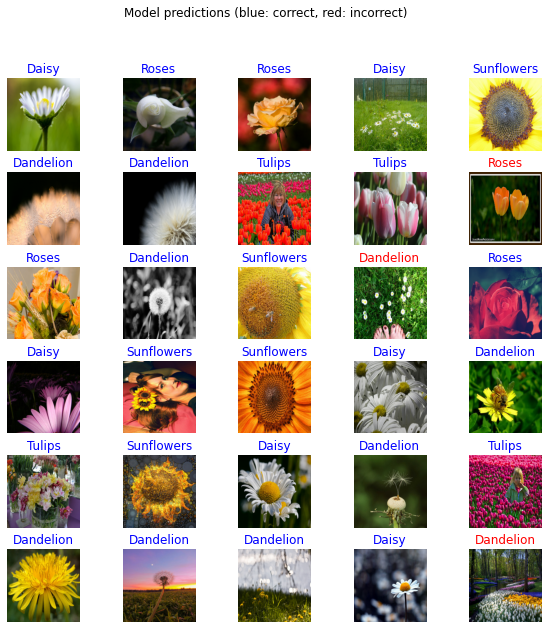

In [8]:
import matplotlib.pyplot as plt

class_names = np.array(dataset_info.features['label'].names)

image_batch, label_batch = next(iter(train))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]


plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

다음과 같이 꽤 정확하게 분류 되었음을 알 수 있습니다

# 5. ResNet
ResNet은 2015년 ILSVRC에서 우승한 아키텍쳐입니다<br>
특히 ResNet은 새로운 유형의 **residual connection을 통해 상당히 깊은 네트워크를 효율적으로 생성할 수 있는 방법을 제공하여 성능을 높였습니다**<br>
특히 **아래와 같이 Residual block을 통한 skip connection을 통해 기존보다 계산해야 할 연산량을 줄였습니다**<br><br>
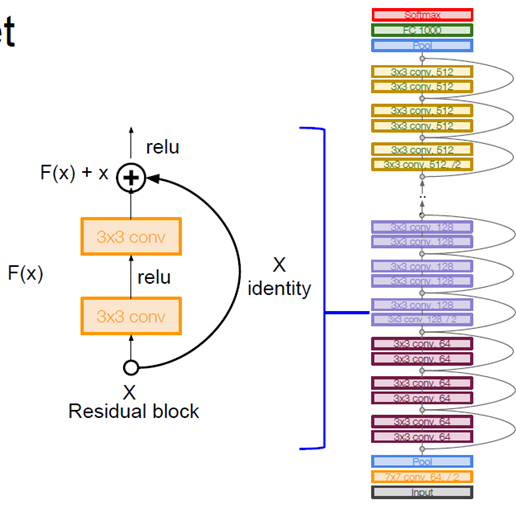

지금부터는 ResNet이 왜 깊은 network에서도 학습이 되는지에 대해서 알아보겠습니다<br>
기존의 Deep한 Network의 문제점은 바로 **Vanishing gradient**였습니다<br>
앞쪽 layer로 갈수록 back propagation에서, weight 갱신 값이 줄어들어 0이 되어 학습이 안되는 현상이 발생하는 것입니다<br>
**ResNet은 이 문제를 이전 layer를 skip connection으로 다음 layer에 연결시켜서, gradient vanishing을 해결합니다**<br>
ResNet은 각 layer의 입력이 다른 구조의 network의 출력이 됩니다.<br>
모든 layer들이 연결되어 깊은 신경망을 형성할 수 있는 것이지요<br>
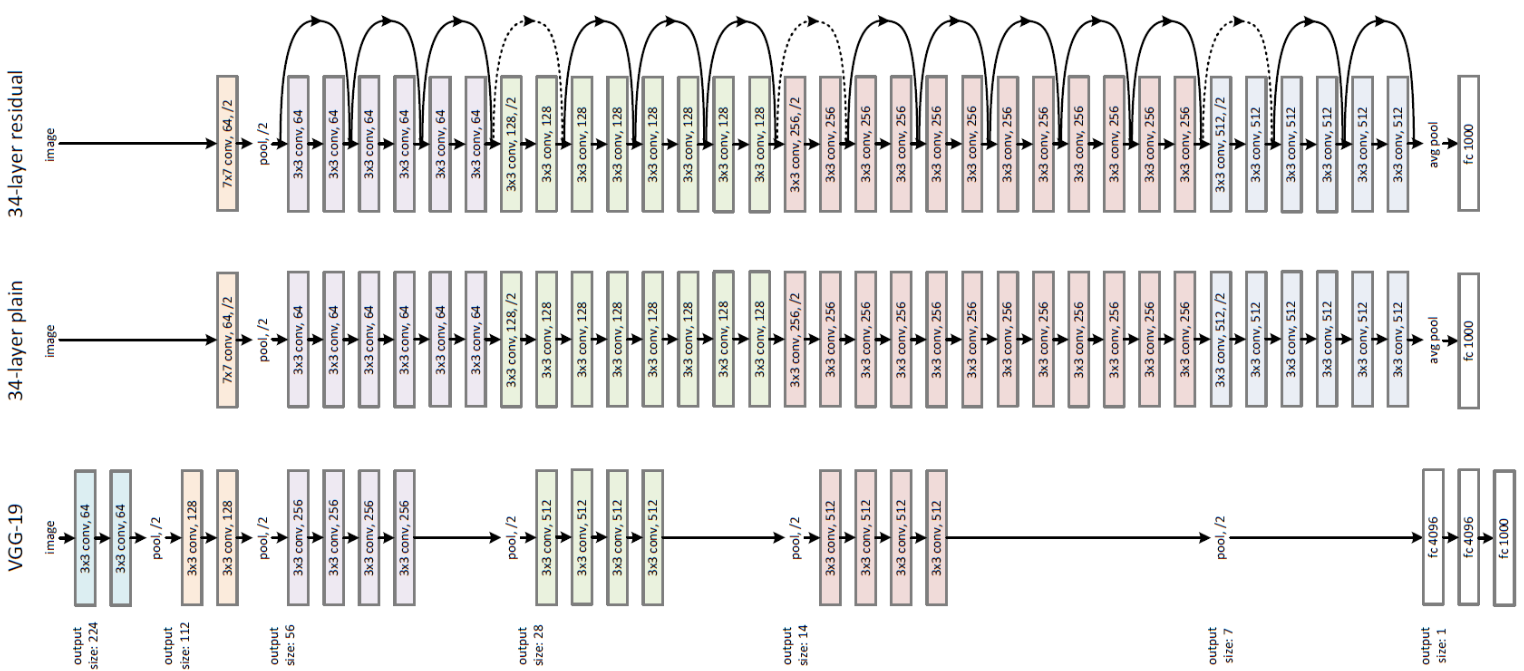
하지만 ResNet이 vanishing gradient를 완전히 해결한 것은 아니며, 많은 논문들이 이를 다루고 있습니다<br>
또한 ResNet-50+ 이상의 모델들은 GoogLeNet과 마찬가지로 **'bottleneck'**을 사용하여서, efficiency를 높입니다<br>
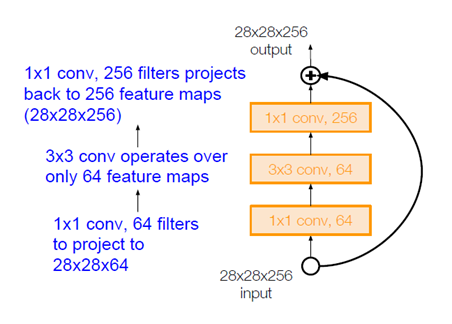

이제 keras을 이용하여 ResNet-50을 직접 구현해 보도록 하겠습니다

In [1]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math
 
# number of classes
K = 4
 
 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

또한, tensorflow 모듈을 통해서 **ResNet50**을 불러올 수 있습니다

In [2]:
import tensorflow as tf
Resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights='imagenet', # imagnet을 통해 사전학습시킨 가중치를 초기값으로 사용
    input_shape=None,
    input_tensor=None,
    pooling=None,
    classes=1000
)

print(Resnet50.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

이제 위에서 사용한 flower데이터를 이용하여 ResNet을 훈련시켜보겠습니다

# Load data

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical    
import numpy as np

(training, validation), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]','train[70%:]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
)

# Print number of classes, Training images, Validation Images
num_classes = dataset_info.features['label'].num_classes

num_train = 0
num_val = 0

for elem in training:
    num_train += 1
for elem in validation:
    num_val += 1

IMAGE_RES = 224
Batch_size = 32

def format_image(image, label):
    image = tf.image.resize(image,(IMAGE_RES, IMAGE_RES))/255.0 # normalize
    return image, label

train = training.shuffle(num_train//4).map(format_image).batch(Batch_size).prefetch(1) # mapping을 이용하여 shuffle 해준다
validation = validation.map(format_image).batch(Batch_size).prefetch(1)

print(train)
print(validation)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


## Compile, train model
이제 GoogLeNet을 이용하여 모델을 직접 빌드하고 훈련시켜 보겠습니다!

In [4]:
Resnet50.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Train
Resnet50.fit(train, batch_size=Batch_size, epochs=40, validation_data=validation)

Epoch 1/40
81/81 [==============================] - 950s 12s/step - loss: 1.1095 - accuracy: 0.7011 - val_loss: 3.3237 - val_accuracy: 0.2352
Epoch 2/40
81/81 [==============================] - 937s 12s/step - loss: 0.4530 - accuracy: 0.8470 - val_loss: 8.5394 - val_accuracy: 0.1844
Epoch 3/40
81/81 [==============================] - 919s 11s/step - loss: 0.3317 - accuracy: 0.8824 - val_loss: 2.3562 - val_accuracy: 0.2352
Epoch 4/40
81/81 [==============================] - 931s 11s/step - loss: 0.2255 - accuracy: 0.9179 - val_loss: 3.1306 - val_accuracy: 0.2352
Epoch 5/40
81/81 [==============================] - 905s 11s/step - loss: 0.2213 - accuracy: 0.9210 - val_loss: 2.7036 - val_accuracy: 0.2352
Epoch 6/40
81/81 [==============================] - 903s 11s/step - loss: 0.1373 - accuracy: 0.9517 - val_loss: 2.7621 - val_accuracy: 0.2352
Epoch 7/40
81/81 [==============================] - 910s 11s/step - loss: 0.1186 - accuracy: 0.9611 - val_loss: 3.8493 - val_accuracy: 0.2452
Epoch 

## visualize model predictions

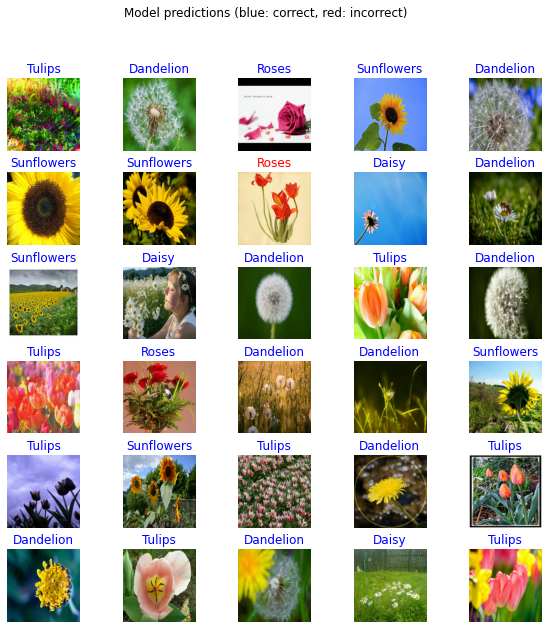

In [5]:
class_names = np.array(dataset_info.features['label'].names)

image_batch, label_batch = next(iter(train))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = Resnet50.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]


plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

ResNet을 이용하여 잘 분류되는 것을 확인 할 수 있었습니다

# LAB
이번 실습도 마찬가지로 위의 모델을 직접 따라 구현해보고, 학습시켜보는 것입니다!

In [6]:
# GoogLeNet
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

model = tf.keras.applications.InceptionV3()

(training, validation), dataset_info = tfds.load('tf_flowers', split = ['train[:70%]','train[70%:]'], with_info = True, as_supervised = True, shuffle_files = True,)

import numpy as np

IMAGE_RES = 299
Batch_size = 32

def format_image(image, label):
    image = tf.image.resize(image,(IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label

train = training.shuffle(num_train // 4).map(format_image).batch(Batch_size).prefetch(1)
validation = validation.map(format_image).batch(Batch_size).prefetch(1)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.fit(train, batch_size = Batch_size, epochs = 20, validation_data = validation)

Epoch 1/20
81/81 [==============================] - 1039s 13s/step - loss: 0.8578 - accuracy: 0.7602 - val_loss: 2.1103 - val_accuracy: 0.5531
Epoch 2/20
81/81 [==============================] - 1044s 13s/step - loss: 0.4028 - accuracy: 0.8657 - val_loss: 1.4373 - val_accuracy: 0.5976
Epoch 3/20
81/81 [==============================] - 1078s 13s/step - loss: 0.3073 - accuracy: 0.8937 - val_loss: 9.5375 - val_accuracy: 0.2906
Epoch 4/20
81/81 [==============================] - 1086s 13s/step - loss: 0.3021 - accuracy: 0.8933 - val_loss: 1.2530 - val_accuracy: 0.5486
Epoch 5/20
81/81 [==============================] - 1064s 13s/step - loss: 0.2331 - accuracy: 0.9159 - val_loss: 0.6942 - val_accuracy: 0.7575
Epoch 6/20
81/81 [==============================] - 1070s 13s/step - loss: 0.2154 - accuracy: 0.9268 - val_loss: 1.0574 - val_accuracy: 0.7802
Epoch 7/20
81/81 [==============================] - 1077s 13s/step - loss: 0.1843 - accuracy: 0.9397 - val_loss: 0.7678 - val_accuracy: 0.8056

In [ ]:
# ResNet
import tensorflow as tf

Resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top = True,
    weights = 'imagenet',
    input_shape = None,
    input_tensor = None,
    pooling = None,
    classes = 1000
)

import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical    
import numpy as np

(training, validation), dataset_info = tfds.load(
    'tf_flowers',
    split = ['train[:70%]','train[70%:]'],
    with_info = True,
    as_supervised = True,
    shuffle_files = True,
)

num_classes = dataset_info.features['label'].num_classes

num_train = 0
num_val = 0

for elem in training:
    num_train += 1
for elem in validation:
    num_val += 1

IMAGE_RES = 224
Batch_size = 32

def format_image(image, label):
    image = tf.image.resize(image,(IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label

train = training.shuffle(num_train // 4).map(format_image).batch(Batch_size).prefetch(1)
validation = validation.map(format_image).batch(Batch_size).prefetch(1)

Resnet50.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

Resnet50.fit(train, batch_size = Batch_size, epochs = 20, validation_data = validation)

Epoch 1/20
81/81 [==============================] - 897s 11s/step - loss: 1.2705 - accuracy: 0.6761 - val_loss: 23.5709 - val_accuracy: 0.2434
Epoch 2/20
81/81 [==============================] - 872s 11s/step - loss: 0.4975 - accuracy: 0.8178 - val_loss: 3.2884 - val_accuracy: 0.2352
Epoch 3/20
81/81 [==============================] - 874s 11s/step - loss: 0.3114 - accuracy: 0.8937 - val_loss: 2.7853 - val_accuracy: 0.2352
Epoch 4/20
81/81 [==============================] - 873s 11s/step - loss: 0.2640 - accuracy: 0.9074 - val_loss: 2.3093 - val_accuracy: 0.2280
Epoch 5/20
81/81 [==============================] - 865s 11s/step - loss: 0.1710 - accuracy: 0.9432 - val_loss: 2.5958 - val_accuracy: 0.2352
Epoch 6/20
81/81 [==============================] - 874s 11s/step - loss: 0.1610 - accuracy: 0.9490 - val_loss: 2.5681 - val_accuracy: 0.2352
Epoch 7/20
81/81 [==============================] - 880s 11s/step - loss: 0.1445 - accuracy: 0.9467 - val_loss: 2.8846 - val_accuracy: 0.2416
Epoch

# Reference
- 실전! 텐서플로 2로 배우는 컴퓨터 비전 딥러닝 chapter 03
- 경희대학교 소프트웨어융합학과 로봇센서데이터 수업 lecture note

## 수고하셨습니다^^